# Title: What is the Myers–Briggs Type Indicator (MBTI) Associated with the Musical Features of a Playlist?

Link to the dataset: https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists
##### By: Roy Hung, CC Liang, Megan Ma, and Joshua Wu

# 1. Introduction
The Myers-Briggs Type Indicator (MBTI), based on the theory of psychological types described by C. G. Jung, describes personality across four axes with a total of sixteen distinct combinations (The Myers & Briggs Foundation). Research shows that musical taste is related to personality, but little evidence demonstrates how predictable musical features are. 

This study attempts to answer the question "What is the Myers–Briggs Type Indicator (MBTI) Associated with the musical features of a playlist?" by analyzing using a k-nearest neighbor classification model. 

The dataset, titled "Spotify MBTI Playlists", contains aggregated information on eleven different musical features for a Spotify playlist on each row.

# 2. Methods and Results

### 2.0 Loading Packages and Seed Setting
The packages allow us to clean and wrangle data, create visualizations, build a classification model, and predict. We set the seed to be 1 and will keep it for the entire data analysis.

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 20)

set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### 2.1 Reading the Dataset
The file is a .csv file with headers. We uploaded the dataset to our remote GitHub repository to read it directly from web. To apply classification to the dataset, we mutate mbti to ensure that it is loaded as categorical data. 

In [2]:
spotify_mbti <- read_csv("https://raw.githubusercontent.com/ccliang4/dsci-100-2022w1-sec-005-group-28/main/combined_mbti_df.csv") |>
    mutate(mbti = as_factor(mbti))
spotify_mbti

Rows: 4081 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): mbti, function_pair
dbl (44): danceability_mean, danceability_stdev, energy_mean, energy_stdev, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mbti,function_pair,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,⋯,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,NF,0.5578409,0.15501057,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,⋯,2,2,1,4,0,0,0,0,0,0
INFP,NF,0.5876364,0.13564425,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,⋯,1,2,1,4,1,1,1,1,0,0
INFP,NF,0.6770000,0.12800941,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,⋯,0,1,1,3,1,0,0,1,2,9
INFP,NF,0.5170000,0.16947739,0.5134119,0.2583449,-10.172833,4.935140,0.7857143,0.4152997,⋯,2,5,0,2,0,1,0,3,0,0
INFP,NF,0.5604000,0.14145007,0.4458620,0.2425917,-10.572240,5.685179,0.8200000,0.3880879,⋯,1,7,2,1,0,0,0,5,1,1
INFP,NF,0.6139355,0.09817941,0.7283871,0.1280338,-6.986581,1.639672,0.5483871,0.5058794,⋯,0,1,3,1,1,2,0,0,1,4
INFP,NF,0.5208000,0.16415747,0.6187520,0.2189640,-7.242380,4.592927,0.6400000,0.4848732,⋯,1,2,1,4,3,0,1,1,2,2
INFP,NF,0.6654000,0.10415608,0.4110800,0.1520283,-10.797560,2.925749,0.2600000,0.4430875,⋯,6,0,0,0,6,3,2,0,1,4
INFP,NF,0.5564000,0.12819309,0.4926400,0.1678913,-9.133600,2.147281,0.9800000,0.1414214,⋯,0,4,0,1,0,0,0,3,1,0


### 2.2 Cleaning and Wrangling Data
The goal of this step is to remove unnecessary columns and NA rows. 

##### 2.2.1 Remove Unused Column
We will remove the function_pair and standard deviation columns as repetitive or merely indicators of variability. We can simply de-select the column.

In [3]:
spotify_mbti_remove_function_pair <- spotify_mbti |>
    select(-function_pair, 
           -danceability_stdev, 
           -energy_stdev, 
           -loudness_stdev, 
           -mode_stdev, 
           -speechiness_stdev, 
           -acousticness_stdev, 
           -liveness_stdev,
           -valence_stdev,
           -tempo_stdev,
           -instrumentalness_stdev)
spotify_mbti_remove_function_pair

mbti,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,⋯,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.5533250,-8.352591,0.6590909,0.06734091,0.29346909,0.1634023,0.4488841,120.95480,⋯,2,2,1,4,0,0,0,0,0,0
INFP,0.5876364,0.5562727,-8.215697,0.6363636,0.07427273,0.34143394,0.1545424,0.4476030,131.87124,⋯,1,2,1,4,1,1,1,1,0,0
INFP,0.6770000,0.8512800,-5.046100,0.5800000,0.27254600,0.05808475,0.2645200,0.2650300,128.20602,⋯,0,1,1,3,1,0,0,1,2,9
INFP,0.5170000,0.5134119,-10.172833,0.7857143,0.05150952,0.44216304,0.1526452,0.3378452,120.59357,⋯,2,5,0,2,0,1,0,3,0,0
INFP,0.5604000,0.4458620,-10.572240,0.8200000,0.06517800,0.47967740,0.1690920,0.3513660,114.69308,⋯,1,7,2,1,0,0,0,5,1,1
INFP,0.6139355,0.7283871,-6.986581,0.5483871,0.28977097,0.18835484,0.2204097,0.5082903,96.37294,⋯,0,1,3,1,1,2,0,0,1,4
INFP,0.5208000,0.6187520,-7.242380,0.6400000,0.06508400,0.26362677,0.1510800,0.4020240,131.27542,⋯,1,2,1,4,3,0,1,1,2,2
INFP,0.6654000,0.4110800,-10.797560,0.2600000,0.08826600,0.23746131,0.1890960,0.4345400,99.42746,⋯,6,0,0,0,6,3,2,0,1,4
INFP,0.5564000,0.4926400,-9.133600,0.9800000,0.04936600,0.57667846,0.1431940,0.3607480,118.52132,⋯,0,4,0,1,0,0,0,3,1,0


##### 2.2.2 Combine Columns
As one major/minor can be transposed easily into another major/minor, we will combine all majors and minors into two columns.

In [4]:
spotify_mbti_major_minor <- spotify_mbti_remove_function_pair |>
    mutate(major_count = CMajor_count + `C#/DbMajor_count` + DMajor_count +
           `D#_EbMajor_count` + EMajor_count + FMajor_count + GMajor_count +
           `G#/AbMajor_count` + AMajor_count + BMajor_count + `A#/BbMajor_count` +
           `F#/GbMajor_count`,
           minor_count = Cminor_count + `C#/Dbminor_count` + Eminor_count +
           Fminor_count + `F#/Gbminor_count` + `G#/Abminor_count` + 
           Aminor_count + `A#/Bbminor_count` + Dminor_count + `D#_Ebminor_count` +
           Gminor_count + Bminor_count) |>
    select(mbti:instrumentalness_mean, major_count, minor_count)
spotify_mbti_major_minor

mbti,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.5533250,-8.352591,0.6590909,0.06734091,0.29346909,0.1634023,0.4488841,120.95480,0.019970993,29,15
INFP,0.5876364,0.5562727,-8.215697,0.6363636,0.07427273,0.34143394,0.1545424,0.4476030,131.87124,0.061040864,21,12
INFP,0.6770000,0.8512800,-5.046100,0.5800000,0.27254600,0.05808475,0.2645200,0.2650300,128.20602,0.250357561,29,21
INFP,0.5170000,0.5134119,-10.172833,0.7857143,0.05150952,0.44216304,0.1526452,0.3378452,120.59357,0.210927153,33,9
INFP,0.5604000,0.4458620,-10.572240,0.8200000,0.06517800,0.47967740,0.1690920,0.3513660,114.69308,0.069537275,41,9
INFP,0.6139355,0.7283871,-6.986581,0.5483871,0.28977097,0.18835484,0.2204097,0.5082903,96.37294,0.028863916,17,14
INFP,0.5208000,0.6187520,-7.242380,0.6400000,0.06508400,0.26362677,0.1510800,0.4020240,131.27542,0.045329397,32,18
INFP,0.6654000,0.4110800,-10.797560,0.2600000,0.08826600,0.23746131,0.1890960,0.4345400,99.42746,0.662444266,13,37
INFP,0.5564000,0.4926400,-9.133600,0.9800000,0.04936600,0.57667846,0.1431940,0.3607480,118.52132,0.003888687,49,1


##### 2.2.3 Check and Remove NA Rows

In [5]:
na_rows <- spotify_mbti_major_minor[!complete.cases(spotify_mbti_major_minor), ]
na_rows
nrow(na_rows)

mbti,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ESFP,0.5853125,0.6943750,-5.307063,0.5625000,0.09024375,0.1539116,0.1578000,0.5220625,122.6099,0.0009960725,9,NA
ESFP,0.5913400,0.6295800,-6.534280,0.6800000,0.06671000,0.2852696,0.1736960,0.5029780,120.6514,0.0108525478,34,NA
ISTJ,0.5542414,0.6090448,-7.820414,0.7931034,0.08745862,0.3659197,0.1741276,0.5095172,122.1670,0.1356378224,23,NA
ISTJ,0.5528800,0.4941400,-9.357180,0.6800000,0.05540600,0.4754843,0.1869280,0.5156200,120.1463,0.0123044960,34,NA


[1] 4

In [6]:
spotify_mbti_cleaned <- spotify_mbti_major_minor |>
    filter(!is.na(minor_count))

spotify_mbti_cleaned

mbti,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.5533250,-8.352591,0.6590909,0.06734091,0.29346909,0.1634023,0.4488841,120.95480,0.019970993,29,15
INFP,0.5876364,0.5562727,-8.215697,0.6363636,0.07427273,0.34143394,0.1545424,0.4476030,131.87124,0.061040864,21,12
INFP,0.6770000,0.8512800,-5.046100,0.5800000,0.27254600,0.05808475,0.2645200,0.2650300,128.20602,0.250357561,29,21
INFP,0.5170000,0.5134119,-10.172833,0.7857143,0.05150952,0.44216304,0.1526452,0.3378452,120.59357,0.210927153,33,9
INFP,0.5604000,0.4458620,-10.572240,0.8200000,0.06517800,0.47967740,0.1690920,0.3513660,114.69308,0.069537275,41,9
INFP,0.6139355,0.7283871,-6.986581,0.5483871,0.28977097,0.18835484,0.2204097,0.5082903,96.37294,0.028863916,17,14
INFP,0.5208000,0.6187520,-7.242380,0.6400000,0.06508400,0.26362677,0.1510800,0.4020240,131.27542,0.045329397,32,18
INFP,0.6654000,0.4110800,-10.797560,0.2600000,0.08826600,0.23746131,0.1890960,0.4345400,99.42746,0.662444266,13,37
INFP,0.5564000,0.4926400,-9.133600,0.9800000,0.04936600,0.57667846,0.1431940,0.3607480,118.52132,0.003888687,49,1


### 2.3 Data Splitting
We will use 75% of our original data for training. We could not stratify the dataset, but since our dataset is large enough, we can keep the data unstratified.

In [7]:
spotify_split <- initial_split(spotify_mbti_cleaned, prop = 0.75)  
spotify_mbti_train <- training(spotify_split)   
spotify_mbti_test <- testing(spotify_split)

## Exploratory Data Analysis (EDA)
We have prepared the data, so we are ready to take the training set to perform exploratory data analysis. 

### 2.4 Summarize the data in tables

##### 2.4.1 Observation Count
We start by reporting the number of observations in each class. To do this, we need to group by mbti and combine the summarize function to count the number of observations.

In [8]:
observation_count <- spotify_mbti_train |>
    group_by(mbti) |>
    summarize(count = n())
observation_count

mbti,count
<fct>,<int>
INFP,231
ENFP,225
INFJ,241
ENFJ,219
INTP,209
ENTP,214
INTJ,223
ENTJ,229
ISFP,214


Table 1. Obervation Count

From Table 1, we can see differences in counts range from two hundred to only eighty. This tells us that we have class imbalance issues. Therefore, we will add an oversampling step to the recipe when we perform the data analysis.

##### 2.4.2 Means of Predictor Variables
Next, we will report the means of all selected predictor variables.

In [9]:
means_table <- spotify_mbti_train |>
    summarize(across(danceability_mean:minor_count, mean, na.rm = TRUE))

glimpse(means_table)

Rows: 1
Columns: 12
$ danceability_mean     <dbl> 0.5937052
$ energy_mean           <dbl> 0.6351733
$ loudness_mean         <dbl> -7.130696
$ mode_mean             <dbl> 0.6026921
$ speechiness_mean      <dbl> 0.0782699
$ acousticness_mean     <dbl> 0.2505405
$ liveness_mean         <dbl> 0.1808428
$ valence_mean          <dbl> 0.4752963
$ tempo_mean            <dbl> 121.892
$ instrumentalness_mean <dbl> 0.07774629
$ major_count           <dbl> 24.80667
$ minor_count           <dbl> 16.30422


Table 2. Means of Predictor Variables

##### 2.4.3 Missing Data
Lastly, we will double-check if we still have any missing data. We can do this by calling the !complete.cases function again.

In [10]:
na_rows <- spotify_mbti_train[!complete.cases(spotify_mbti_train), ]
na_rows
nrow(na_rows)

mbti,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 0

Table 3. Missing Data

As expected, we no longer have any missing data as seen in Table 3.

#### 2.5 Visualize the data with plots
Since there are many predictor variables for this classification problem, we can randomly select a few, plot them using scatterplots, and check for relationships. In particular, we will make sure to colour the plot according to the class, or mbti.

##### 2.5.1 Plot Loudness vs. Liveness

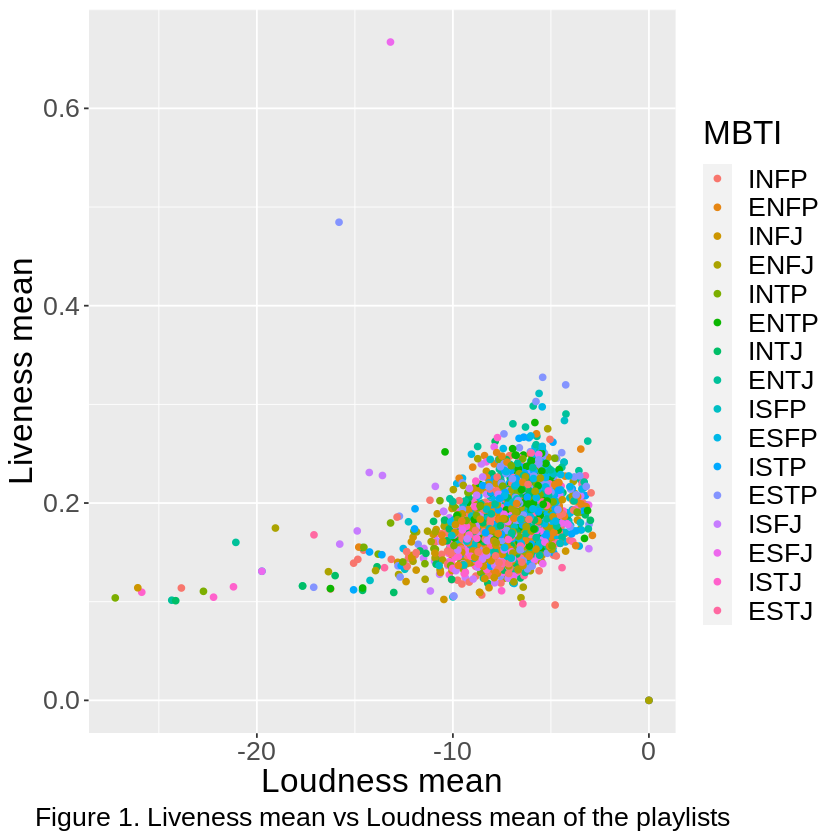

In [11]:
loudness_liveness_mean <- spotify_mbti_train |>  
    ggplot(aes(x = loudness_mean, 
               y = liveness_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Loudness mean",
             y = "Liveness mean",
            colour = 'MBTI',
        caption = 'Figure 1. Liveness mean vs Loudness mean of the playlists') +
    theme(text = element_text(size = 20),
         plot.caption = element_text(hjust=0.5))
loudness_liveness_mean

As shown in Figure 1, there is no relationship between the liveness mean and loudness mean of the playlists.

##### 2.5.2 Plot Tempo vs. Major Count

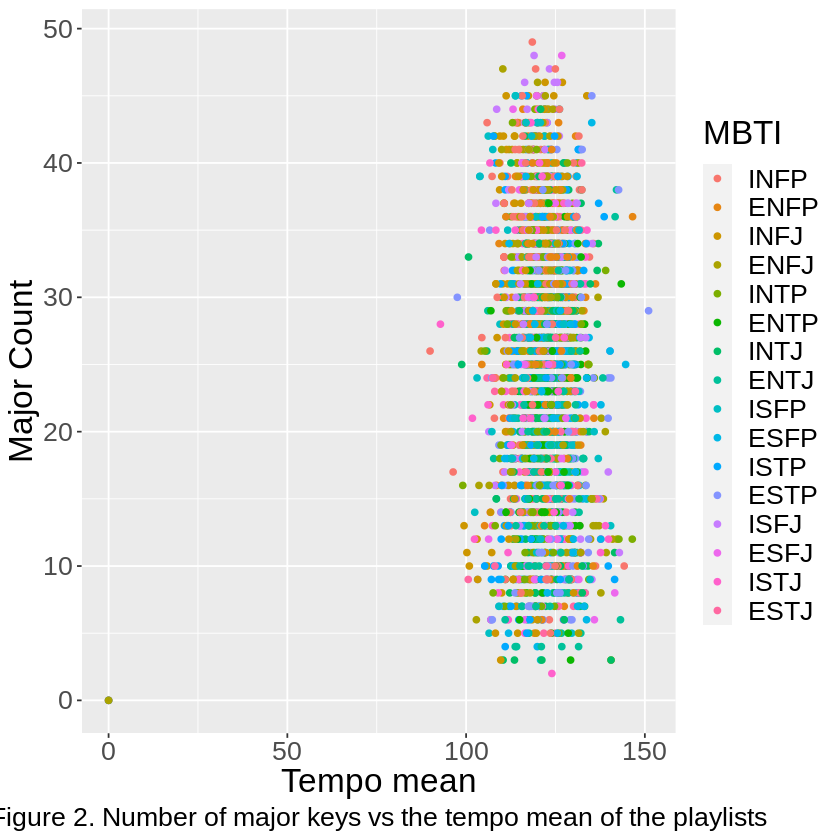

In [12]:
tempo_major_count <- spotify_mbti_train |>  
    ggplot(aes(x = tempo_mean, 
               y = major_count, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Tempo mean",
             y = "Major Count",
            colour = 'MBTI',
          caption = "Figure 2. Number of major keys vs the tempo mean of the playlists") +
    theme(text = element_text(size = 20),
         plot.caption = element_text(hjust=0.5))
tempo_major_count

As shown in Figure 2, there is no relationship between the count of major keys and tempo means of the playlists.

##### 2.5.3 Plot Danceability vs. Energy

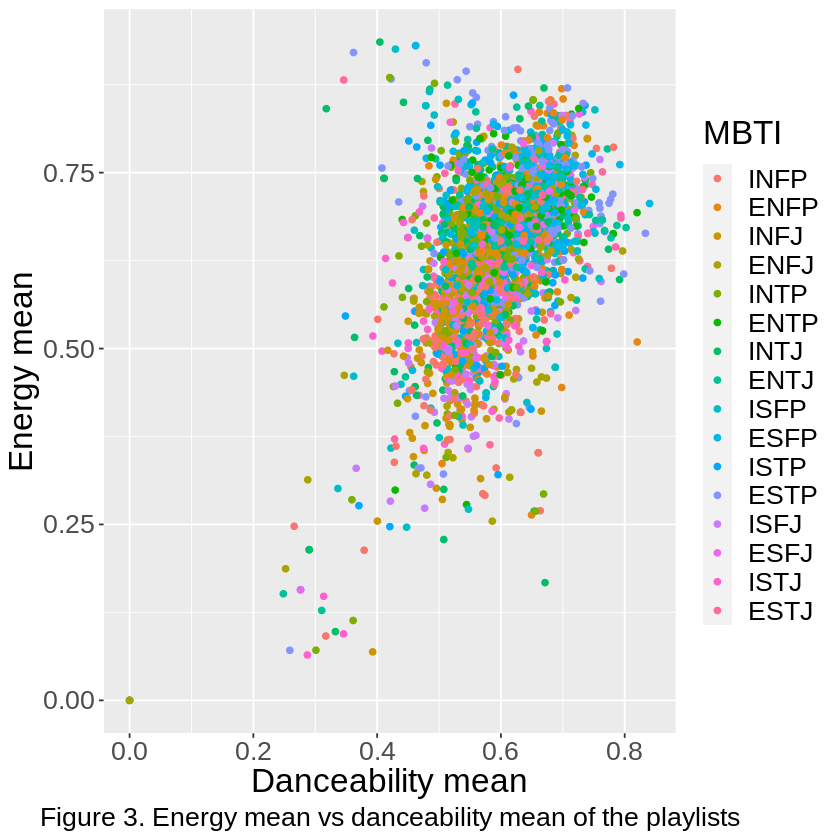

In [13]:
danceability_energy_mean <- spotify_mbti_train |>  
    ggplot(aes(x = danceability_mean, 
               y = energy_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Danceability mean",
             y = "Energy mean",
            colour = 'MBTI',
        caption = 'Figure 3. Energy mean vs danceability mean of the playlists') +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust=0.5))
danceability_energy_mean

As shown in Figure 3, there is a weak positive relationship between the energy mean and danceability mean of the playlists. As the deanceability mean of the playlists increases, the energy mean increases.

## Conclusion of the Exploratory Data Analysis (EDA)
From the EDA, we learnt:
1. We have some balancing issue that needs to be fixed when creating the recipe for the classification model.
2. We have successfully removed all NA rows.
3. Most predictor variables do not have relationships with each other, but some might have.

### 2.6 Outline
##### Data Analysis
We will conduct our data analysis using the K-nearest neighbors classification to predict MBTI from the musical features of Spotify playlists. Our predictors includes means of all variables and key count. We also put all the majors into one column and all the minors into another. Furthermore, cross-validation will be used to tune the number of neighbors to optimize the model's performance.

##### Visualization
We will visualize the results by creating a heatmap and bar plot with the number of correctly identified MBTI types plot against the number of incorrectly identified MBTI type for the confusion matrix.

## Data Analysis

### 2.7 Tuning the Classifier

##### 2.7.1 Recipe
We will begin by creating the recipe as well as scaling and centering all predictor variables. 

In [14]:
spotify_mbti_recipe <- recipe(mbti ~ ., data = spotify_mbti_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

spotify_mbti_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         12

Operations:

Scaling for all_predictors()
Centering for all_predictors()

We need to fix the class imabalance issues by first installing the themis package.

In [15]:
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Then, we can load the package and apply the step_upsample to ensure that all mbti have the same number of observations.

In [16]:
library(themis)
spotify_mbti_recipe_ups <- spotify_mbti_recipe |>
    step_upsample(mbti, over_ratio = 1, skip = FALSE)

spotify_mbti_recipe_ups

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         12

Operations:

Scaling for all_predictors()
Centering for all_predictors()
Up-sampling based on mbti

##### 2.7.2 5-Fold Cross-Validation
To ensure that we are choosing the best parameter K, we need to evaluate the classifier using only the training data using cross-validation.

In [17]:
spotify_mbti_vfold <- vfold_cv(spotify_mbti_train, v = 5)

##### 2.7.3 Model Specification for Tuning
Now that we have the recipe and vfold, we need to create the model specification for tuning. 

In [18]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

##### 2.7.4 Tibble of K Values
To test the classification model on various parameter K, we also need to create a tibble of different k values for the model to perform cross-validation on. Since we have a large dataset, we will try a larger range of k values.

In [19]:
k_vals <- tibble(neighbors = seq(from = 20, to = 120, by = 20))

##### 2.7.5 Putting Everything into a Workflow for Training
Now we can finally fit the model for each value in the range of parameter values that we selected and runs cross-validation on each train/validation split.

In [20]:
knn_results <- workflow() |>
    add_recipe(spotify_mbti_recipe_ups) |>
    add_model(knn_tune) |>
    tune_grid(resamples = spotify_mbti_vfold, grid = k_vals) |>
    collect_metrics()

knn_results

x Fold1: preprocessor 1/1, model 1/1 (predictions):
  Error in `predict_model()`:
  ! Some assessment set rows are not available at prediction t...

x Fold2: preprocessor 1/1, model 1/1 (predictions):
  Error in `predict_model()`:
  ! Some assessment set rows are not available at prediction t...

x Fold3: preprocessor 1/1, model 1/1 (predictions):
  Error in `predict_model()`:
  ! Some assessment set rows are not available at prediction t...

x Fold4: preprocessor 1/1, model 1/1 (predictions):
  Error in `predict_model()`:
  ! Some assessment set rows are not available at prediction t...

x Fold5: preprocessor 1/1, model 1/1 (predictions):
  Error in `predict_model()`:
  ! Some assessment set rows are not available at prediction t...

Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


##### 2.7.6 Filter for Accuracy
To understand how well each parameter is performing, we filter the row "accuracy" and put it into a separate data frame. 

In [21]:
accuracies_training <- filter(knn_results, .metric == "accuracy") 
accuracies_training

ERROR: Error in filter(knn_results, .metric == "accuracy"): object 'knn_results' not found


##### 2.7.7 Plot of Estimated Accuracy vs. the Number of Neighbors
To better visualize the accuracy, we will create a plot. This also helps with checking whether we see a curve in trend.

In [22]:
accuracy_vs_k <- ggplot(accuracies_training, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate (Proportion)", 
        caption = 'Figure 4. Plot of Estimated Accuracy vs. the Number of Neighbors') +
    ggtitle("Plot of K vs. Accuracy") +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust=0.5))

accuracy_vs_k

ERROR: Error in ggplot(accuracies_training, aes(x = neighbors, y = mean)): object 'accuracies_training' not found


As seen in Figure 4, we do have some kind of curve, where the two sides have lower accuracy compared to the middle.

##### 2.7.8 Max Accuracy for Best Value of K
We can filter for the row with the highest accuracy by looking at the mean.

In [ ]:
max_accuracy <- accuracies_training |>
    select(neighbors, mean) |>
    filter(mean == max(mean))
max_accuracy

Table 4. Accuracy

Table 4 shows that the best K value is 40, which we can then apply to our model specification.

### 2.8 Retraining the Model and Predicting

##### 2.8.1 Recreate the Model Specification with the Best K
We will create a model specification with the best parameter K for the classifier and apply it to our data analysis.

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 40) |>
    set_engine("kknn") |>
    set_mode("classification")

##### 2.8.2 Retrain the Classifier with the Best Value for K
Taking the new model specification and reusing the recipe, we can fit everything into the model.

In [ ]:
knn_fit <- workflow() |>
    add_recipe(spotify_mbti_recipe_ups) |>
    add_model(knn_spec) |>
    fit(data = spotify_mbti_train)

##### 2.8.3 Predictions with the Testing Set
Then, we can use the classification model to predict the original data. We need to ensure that we are predicting using the testing set.

In [ ]:
spotify_mbti_predictions <- predict(knn_fit, spotify_mbti_test) |>
    bind_cols(spotify_mbti_test)

spotify_mbti_predictions

##### 2.8.4 Computing Accuracies
Finally, we can assess the performance of our classification model. We can use the metrics function and specify the truth and estimate arguments.

In [ ]:
model_accuracies <- spotify_mbti_predictions |>
  metrics(truth = mbti, estimate = .pred_class) |>
  filter(.metric == "accuracy")
model_accuracies

Table 5. Model Accuracies

From Table 5, we can see that the accuracy of this model is 0.2196, which is very low. It tells us that the classification model is highly unreliable for predicing the MBTI based on the musical characteristics.

## Data Visualization

### 2.9 Visualizing Confusion Matrix

##### 2.9.1 Confusion Matrix
We can start by creating a confusion matrix.

In [ ]:
confusion <- conf_mat(spotify_mbti_predictions, truth = mbti, estimate = .pred_class)

confusion

Table 6. Confusion Matrix

Currently, we can tell that due to the large number of classes that exist in the dataset, a confusion matrix is not ideal for visualizing as we cannot see right away how accurate or inaccurate our model is.

##### 2.9.2 Heatmap
To visualize the confusion matrix, we will utilize the "ggplot2::autoplot()" function to create a heatmap.

In [ ]:
conf_hm = confusion |>
    ggplot2::autoplot(type = "heatmap") +
    labs(caption = "Figure 7. Heatmap of confusion matrix") +
    ggtitle("Confusion Heatmap") +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust=0.5))

conf_hm

We can now visualize our confusion matrix much easier, as it fits all into one plot and the color gradient allows us to better see trends.

### 2.10 Bar Chart

Another way that would be helpful in our data visualization is by creating a bar chart that allows us to see what proportion of our predictions were correct. 

##### 2.10.1 Store Truth and Prediction Columns in a New Data Frame
We can simply select the truth column (mbti) and the prediction column (.pred_class) and group them by their truth column.

In [ ]:
conf_df = spotify_mbti_predictions |>
        select(mbti, .pred_class) |>
        group_by(mbti)

##### 2.10.2 Count of Correct and Incorrect Predictions
We create a new dataframe containing the total number of correct and incorrect predictions. The is_correct is created by matching the truth and prediction columns and counting.

In [ ]:
df_count = conf_df |>
        mutate(is_correct = mbti == .pred_class) |>
        group_by(mbti, .pred_class) |>
        summarise(n_correct = sum(is_correct), n_incorrect = sum(!is_correct)) |>
        ungroup() |>
        select(-.pred_class)

##### 2.10.3 Create a New Bar Graph with Two Bars per MBTI
Finally, to visualize the predictions, we create two bars for each MBTI: Number of Correct Predictions and Number of Incorrect Predictions. Specifically, we will also choose colour-blind friendly colours.

In [ ]:
count_plot = df_count |>
        ggplot() +
        geom_bar(aes(x = mbti, y = n_correct, fill = "Number of Correct Predictions"), 
                 stat = "identity", 
                 position = "identity") +
        geom_bar(aes(x = mbti, y = n_incorrect, fill = "Number of Incorrect Predictions"), 
                 stat = "identity", 
                 width = 0.5, 
                 position = position_dodge(width = 1)) +
        labs(x = "MBTI", 
             y = "Number of correct predictions",
             caption = "Figure 8. Bar Graph of Number of Correct Predictions vs Number of Incorrect Predictions per MBTI",
             fill = "Legend",
             title = "Graph of Correct vs Incorrect Predictions") +
        theme(text = element_text(size = 15),
             plot.caption = element_text(hjust=0.5)) +
        scale_fill_manual(values = c("Number of Correct Predictions" = "cyan", "Number of Incorrect Predictions" = "red"))

count_plot

# 3. Discussion

### 3.1 Summary of the Results
From our data analysis and visualizations, we see in Table 5 that the accuracy of the classification model we have created is 0.2196. This value is significantly low, so we argue that we cannot effectively predict one's MBTI type given the selected musical features (danceability, energy, loudness, mode, speechiness, acousticness, liveness, valence, tempo, instrumentalness, major count, and minor count) of a playlist. In addition, we notice from Figure 6 that INFP, ENFJ, ESFP, ISTP, ESFJ, ISTJ, and ESTJ are predicted incorrectly more times than they are predicted correctly, showing that these MBTI types are the most incorrectly predicted.

### 3.2 Comparing Expectations and Findings
We expected to predict the associated MBTI based on musical characteristics but our classification model produced a critically low accuracy. Instead of seeking relationships between MBTI and each musical feature, our finding supports that MBTI may indeed be a form of pseudopsychology as the correlation between music and personality is evident, yet musical characteristics failed to predict MBTI. To improve the accuracy, we should seek another personality type indicator that is verified by the psychology community, such as the Big Five Personality Test.

### 3.3 The Impacts of Our Findings
Due to the results of our findings, we are unable to confidently utilize our model for many of the purposes we outlined in our proposal, such as personal improvement, advertisement and music recommendation algorithms. Because of this, we recommend users to not limit their taste in music to a given personality trait, as many different types of people may enjoy the same type of music. We would also say that companies in the music/streaming industry should not use MBTI as a way of recommending or advertising certain types of music; however there may be ways to achieve these goals using other measurements of personality.

### 3.4 Future Questions that This Study Leads to

Computationally, we can ask the following question: can we tune other parameters of the KNN model or use other models to improve the accuracy of the predictions? We can try tuning KNN parameters like leaf size or use support vector machines or deep neural networks and see if the accuracy can be improved. 

Musically, we can explore which musical characteristic that we explored had the greatest weight on predicting the MBTI. We can also explore if other musical characteristics that we have not considered in our dataset have more associations with the MBTI. This can ultimately help us better recommend musical playlists based on individual personalities. 


# 4. References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

* https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists
* https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/
* https://www.verywellmind.com/music-and-personality-2795424
* https://www.123test.com/personality-test/
* https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
* https://www.16personalities.com/articles/music-preferences-by-personality-type

